<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/AutoencoderBasico_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nos descargamos las imágenes con un ancho de 256 de ancho. Vamos a ir escalando a 64, 128 y 256. Lo haremos con cv2.resize()

In [1]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-25 09:35:34 URL:https://uce3d793ed4f9a85e70b2cde13db.dl.dropboxusercontent.com/cd/0/inline2/Bn2kcWGu_c9q3MiNNzHI38I_UpjAYzkzxmOD9c0XB3-co5E-fMbTal2mC5WblVzgq9yAlWIY09Jnrj7uHnHjZQEf-loHB9T2FEX7rMj_YkTrG-Mxi_spEurfCF0sx6dR0PvnIvnX0Q87D4I-LlQqwcTjJU8GroFl2LOKScISt3Ib9ZPhSQGWnv3a_TEfWbiwU3SAKBFyC-HftcNzmbq9fcWuc8WQqaJgENBundvrlJy8NOMgB0qqYyC9e-ERETgSTpfYfPifPpsYngOki3Hbwof5ge6hrrG6pdhh_eGE-Fx-ni6m0izqqn1ff-iLzpJYnFuCMq3BuYOG7ea6e4QeBWBf-nUkFcVsT-kG_1w6EteTuVGVCOyDSASIqOfRHrxg_hAQCg3MPkyv7Ub_sS0_LDv4eXL8-rWnUrB1DVPYYM8Ljw/file [138777773/138777773] -> "train.zip" [1]
2022-06-25 09:35:38 URL:https://uc96a34394aa0eea33f2c03404c0.dl.dropboxusercontent.com/cd/0/inline2/Bn0DyM58lslQqsTnKbj9b93eU3ueXwf-hGBuoe9osPjjPyPPdjUvNEHB7P7GveyO5eTwinhBse59p4wemxzgEXGUjYXCiSGg1Z3cOJsf-PZINYjpXmw4LjGEuHvwKTYLJST7p2Prl2PGgHhKFJSegJClChUW7SmmaCo24cDPhIYeGSmqDbYDnP27SwCd5m0slK16j_ccr2tHB0h5KI-BF5_iiOydeuyXLmm1D9qArh6Bb4u7yvpkhTAWj6RXUnFG4leOiidF5TXwWSsgOpIXGv2YcsfNZf27TprutNJqvrMAqDNh2hXAMQ01J54_LAwu-U-

In [2]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

## Librerías

In [3]:
import PIL
import cv2
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [4]:
trainPath = 'Training_Set_Pre/'
testPath  = 'Test_Set_Pre/'
valPath  =  'Evaluation_Set_Pre/'

In [6]:
df_train = pd.read_csv(trainPath + '/train.csv')
df_test = pd.read_csv(testPath + '/test.csv')
df_val = pd.read_csv(valPath + '/val.csv')

## Preparación de datos

### Crear Arrays

In [45]:
IMG_SIZE = 128

In [46]:
import shutil

def getNpArray(df, pathO):
  normal, enfermedad = [], []
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    image = cv2.imread(pathO + '/' + str(id) + '.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    if(int(enf)==0):
      normal.append(np.asarray(image))
    else:
      enfermedad.append(np.asarray(image))
  return np.array(normal), np.array(enfermedad)

In [47]:
normalTrain, enfermedadTrain = getNpArray(df_train, trainPath + 'Training/')
normalTest, enfermedadTest = getNpArray(df_test, testPath + 'Test/')
normalVal, enfermedadVal = getNpArray(df_val, valPath + 'Validation/')

In [48]:
normalTrain.shape

(401, 128, 128, 3)

In [49]:
normalTest.shape

(134, 128, 128, 3)

Ya la tenemos reescalada a la medida deseada:

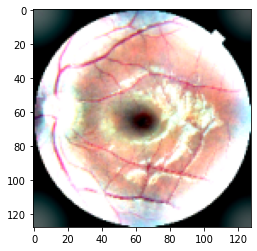

In [50]:
plt.imshow(normalTrain[0])

## Autoencoder

In [51]:
input_img = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))

### Encoder

In [52]:
# Capa convolucional con 32 filtros de tamaño 3x3 seguida de una función de activación relu y aplicando padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
# Capa de max pooling con filtro de tamaño 2x2 y aplicando padding
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

### Decoder

In [53]:
# Capa convolucional con 32 filtros de tamaño 3x3 seguida de una función de activación relu y aplicando padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
 # Capa de upsampling con filtro de tamaño 2x2 y aplicando padding
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [54]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [55]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248

### Entrenamiento

In [56]:
normalTrain.shape

(401, 128, 128, 3)

In [57]:
# trainTest = np.concatenate([normalTrain, normalTest, normalVal])

In [58]:
autoencoder.fit(normalTrain, normalTrain,
                epochs=50,
                batch_size=128,
                validation_data=(normalVal, normalVal))

Epoch 1/50
4/4 [==============================] - 19s 4s/step - loss: -4625.6099 - val_loss: -27987.9102
Epoch 2/50
4/4 [==============================] - 17s 4s/step - loss: -46326.8633 - val_loss: -118329.3516
Epoch 3/50
4/4 [==============================] - 16s 4s/step - loss: -179165.2031 - val_loss: -408662.5625
Epoch 4/50
4/4 [==============================] - 17s 4s/step - loss: -594144.4375 - val_loss: -1248418.7500
Epoch 5/50
4/4 [==============================] - 16s 4s/step - loss: -1751211.1250 - val_loss: -3447923.5000
Epoch 6/50
4/4 [==============================] - 16s 4s/step - loss: -4718675.0000 - val_loss: -8838718.0000
Epoch 7/50
4/4 [==============================] - 16s 4s/step - loss: -11827789.0000 - val_loss: -21159486.0000
Epoch 8/50
4/4 [==============================] - 16s 4s/step - loss: -27785484.0000 - val_loss: -47748760.0000
Epoch 9/50
4/4 [==============================] - 16s 4s/step - loss: -61542624.0000 - val_loss: -101998872.0000
Epoch 10/50
4/

### Pruebas

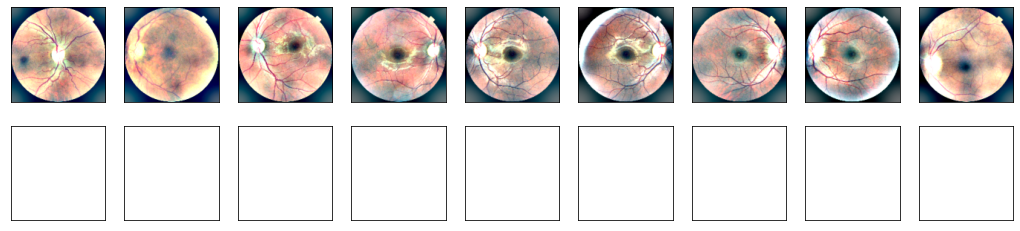

In [59]:
decoded_imgs = autoencoder.predict(normalTest)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    ax = plt.subplot(2, n, i)
    plt.imshow(normalTest[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

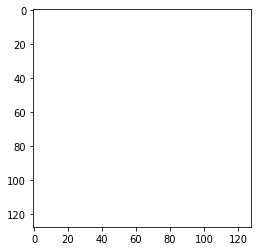

In [60]:
plt.imshow(decoded_imgs[0])

## Diferente Arquitectura

https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726

In [61]:
import numpy as np
from tensorflow import keras

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras import optimizers
from tensorflow.keras.optimizers import Adam

In [62]:
autoencoder = Sequential()
autoencoder.add(Dense(3, activation='elu', input_shape=(IMG_SIZE,IMG_SIZE,3)))
autoencoder.add(Dense(64,  activation='elu'))
autoencoder.add(Dense(10,    activation='linear', name="bottleneck"))
autoencoder.add(Dense(64,  activation='elu'))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(3,  activation='sigmoid'))
autoencoder.compile(loss='binary_crossentropy', optimizer = Adam())

In [63]:
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128, 128, 3)       12        
                                                                 
 dense_6 (Dense)             (None, 128, 128, 64)      256       
                                                                 
 bottleneck (Dense)          (None, 128, 128, 10)      650       
                                                                 
 dense_7 (Dense)             (None, 128, 128, 64)      704       
                                                                 
 dense_8 (Dense)             (None, 128, 128, 128)     8320      
                                                                 
 dense_9 (Dense)             (None, 128, 128, 3)       387       
                                                                 
Total params: 10,329
Trainable params: 10,329
Non-trai

In [64]:
trained_model = autoencoder.fit(
    normalTrain, normalTrain, 
    batch_size=1024, 
    epochs=50, 
    validation_data=(normalVal, normalVal))

Epoch 1/50
1/1 [==============================] - 26s 26s/step - loss: 198.6964 - val_loss: -238.9752
Epoch 2/50
1/1 [==============================] - 20s 20s/step - loss: -249.1798 - val_loss: -667.6808
Epoch 3/50
1/1 [==============================] - 19s 19s/step - loss: -691.1470 - val_loss: -1103.7981
Epoch 4/50
1/1 [==============================] - 18s 18s/step - loss: -1140.0143 - val_loss: -1558.5422
Epoch 5/50
1/1 [==============================] - 18s 18s/step - loss: -1607.7540 - val_loss: -2040.2323
Epoch 6/50
1/1 [==============================] - 18s 18s/step - loss: -2103.3020 - val_loss: -2551.7314
Epoch 7/50
1/1 [==============================] - 18s 18s/step - loss: -2629.8555 - val_loss: -3095.0537
Epoch 8/50
1/1 [==============================] - 18s 18s/step - loss: -3189.5352 - val_loss: -3677.9412
Epoch 9/50
1/1 [==============================] - 17s 17s/step - loss: -3790.1096 - val_loss: -4303.6836
Epoch 10/50
1/1 [==============================] - 18s 18s/st

In [65]:
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
encoded_data = encoder.predict(normalTrain)  # bottleneck representation
decoded_output = autoencoder.predict(normalTrain)        # reconstruction
encoding_dim = 10

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

In [66]:
predicts = autoencoder.predict(normalTest)

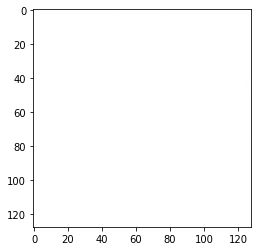

In [67]:
plt.imshow(predicts[4])

## Otra arquitectura mas compleja

https://medium.com/analytics-vidhya/image-anomaly-detection-using-autoencoders-ae937c7fd2d1

In [72]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_layer')
# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)
# Conv Block 2 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# Conv Block 3 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)
#Decoder
# DeConv Block 1-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# DeConv Block 2-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# DeConv Block 3-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)
# output
outputs = tf.keras.layers.Conv2DTranspose(3, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

In [73]:
autoencoder = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

In [74]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 128, 128, 32)     128       
 tion)                                                           
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 128, 128, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 64, 64, 64)        18496     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 64, 64, 64)       256       
 tion)                                                     

In [75]:
hist=autoencoder.fit(normalTrain, normalTrain,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(normalVal, normalVal)
                )

Epoch 1/50
4/4 [==============================] - 26s 6s/step - loss: -0.8018 - val_loss: -83.9280
Epoch 2/50
4/4 [==============================] - 23s 5s/step - loss: -83.7073 - val_loss: -366.0817
Epoch 3/50
4/4 [==============================] - 23s 5s/step - loss: -139.3926 - val_loss: -928.9920
Epoch 4/50
4/4 [==============================] - 23s 5s/step - loss: -183.1871 - val_loss: -1632.3422
Epoch 5/50
4/4 [==============================] - 23s 5s/step - loss: -224.0223 - val_loss: -2169.5662
Epoch 6/50
4/4 [==============================] - 23s 5s/step - loss: -264.4917 - val_loss: -2356.0388
Epoch 7/50
4/4 [==============================] - 23s 5s/step - loss: -304.8045 - val_loss: -2412.8179
Epoch 8/50
4/4 [==============================] - 26s 6s/step - loss: -345.5748 - val_loss: -2525.3105
Epoch 9/50
4/4 [==============================] - 28s 6s/step - loss: -387.5107 - val_loss: -2703.1477
Epoch 10/50
4/4 [==============================] - 23s 6s/step - loss: -430.2118

In [76]:
predicts = autoencoder.predict(normalTest)

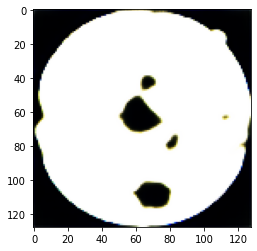

In [77]:
plt.imshow(predicts[21])

In [78]:
predicts = autoencoder.predict(enfermedadTest)

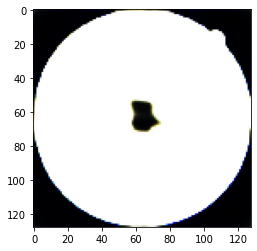

In [79]:
plt.imshow(predicts[21])

## Otra alternativa

In [ ]:
normalTrain.shape[3]

In [ ]:
model = keras.Sequential(
    [
        layers.Input(shape=(normalTrain.shape[1], normalTrain.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=64, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
model.summary()

In [ ]:
model.fit(
    normalTrain,
    normalTrain,
    epochs=50,
    batch_size=128,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)